# Data preparation

In [1]:
import pickle
from pathlib import Path
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
import numpy as np



import configuration as config

## 1. Load combined data

In [3]:
data_df=pd.read_csv(config.COMBINED_DATAFILE)

## 2. Combine origin/destination to 'route'

In [4]:
print(data_df.head())

  origin destination  departure_time tail_number  incident
0    LGA         ORF          1338.0      N915XJ         0
1    DTW         MSN           821.0      N907XJ         0
2    MSP         BIS           901.0      N166PQ         0
3    BIS         MSP          1135.0      N166PQ         0
4    MSN         DTW           928.0      N907XJ         0


In [5]:
airport_features=['origin','destination']

print('Unique levels by feature')
data_df[airport_features].nunique()


Unique levels by feature


origin         5885
destination    5915
dtype: int64

In [6]:
print(data_df['origin'].value_counts().head(15))


origin
ATL    29050
ORD    26221
DFW    25948
DEN    25883
CLT    21120
PHX    17444
LAX    16778
LAS    15759
SEA    14375
IAH    13797
MCO    13604
LGA    13009
SFO    12223
BOS    11879
EWR    11804
Name: count, dtype: int64


In [7]:
print(data_df['destination'].value_counts().head(15))

destination
ATL    29041
ORD    26187
DFW    25956
DEN    25850
CLT    21104
PHX    17444
LAX    16785
LAS    15753
SEA    14373
IAH    13796
MCO    13614
LGA    13028
SFO    12229
BOS    11870
EWR    11798
Name: count, dtype: int64


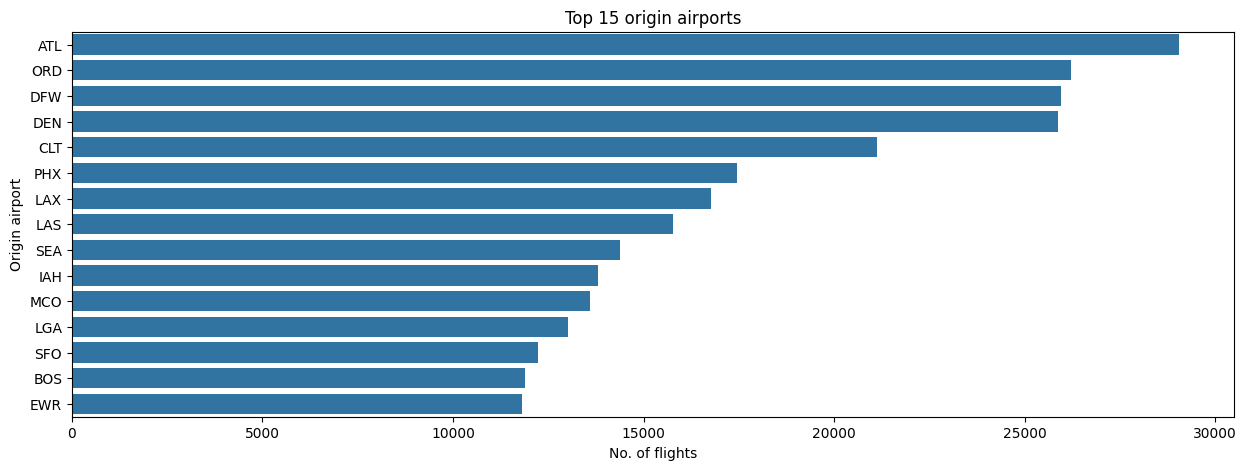

In [8]:

# Plot origin airport level counts
plt.figure(figsize=(15, 5))
level_counts=data_df['origin'].value_counts().head(15).index
sns.countplot(data=data_df, y='origin', order=level_counts)

plt.title('Top 15 origin airports')
plt.xlabel('No. of flights')
plt.ylabel('Origin airport');
plt.show()


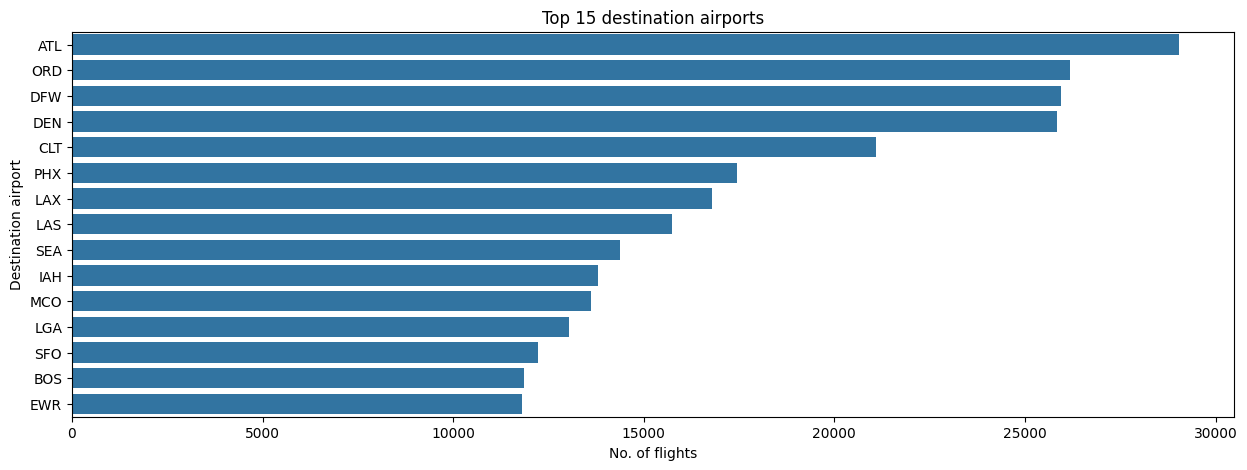

In [9]:
# Plot origin airport level counts
plt.figure(figsize=(15, 5))
level_counts=data_df['destination'].value_counts().head(15).index
sns.countplot(data=data_df, y='destination', order=level_counts)

plt.title('Top 15 destination airports')
plt.xlabel('No. of flights')
plt.ylabel('Destination airport');
plt.show()

In [10]:
data_df['incident'].value_counts()

incident
0    631177
1     14393
Name: count, dtype: int64

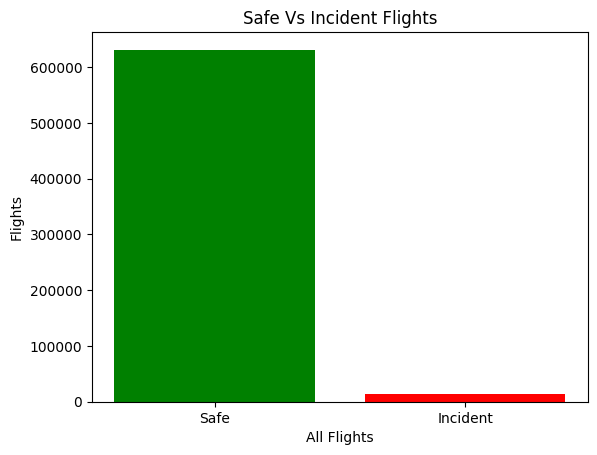

In [11]:
level_counts=data_df['incident'].value_counts()
new_labels = ['Safe', 'Incident']
plt.bar(list(range(len(level_counts))), level_counts, tick_label=level_counts.index, color=('green', 'red'))
plt.title('Safe Vs Incident Flights')
plt.xlabel('All Flights')
plt.xticks(range(len(level_counts)), new_labels)
plt.ylabel('Flights')
plt.show()


In [12]:
print(data_df.head())

  origin destination  departure_time tail_number  incident
0    LGA         ORF          1338.0      N915XJ         0
1    DTW         MSN           821.0      N907XJ         0
2    MSP         BIS           901.0      N166PQ         0
3    BIS         MSP          1135.0      N166PQ         0
4    MSN         DTW           928.0      N907XJ         0


In [13]:

data_df['route'] = data_df['origin'] + '_' + data_df['destination']

print(data_df.head())

  origin destination  departure_time tail_number  incident    route
0    LGA         ORF          1338.0      N915XJ         0  LGA_ORF
1    DTW         MSN           821.0      N907XJ         0  DTW_MSN
2    MSP         BIS           901.0      N166PQ         0  MSP_BIS
3    BIS         MSP          1135.0      N166PQ         0  BIS_MSP
4    MSN         DTW           928.0      N907XJ         0  MSN_DTW


## 3. Encode departure time

In [14]:
cyclical_encoded_data_df = data_df.copy()

cyclical_encoded_data_df.head().T

,0,1,2,3,4
origin,LGA,DTW,MSP,BIS,MSN
destination,ORF,MSN,BIS,MSP,DTW
departure_time,1338.0,821.0,901.0,1135.0,928.0
tail_number,N915XJ,N907XJ,N166PQ,N166PQ,N907XJ
incident,0,0,0,0,0
route,LGA_ORF,DTW_MSN,MSP_BIS,BIS_MSP,MSN_DTW


In [15]:
# Function to convert HHMM format to minutes since midnight
def hhmm_to_minutes(hhmm):
    hhmm_int = int(hhmm)
    hours = hhmm // 100
    minutes = hhmm % 100
    return hours * 60 + minutes

# Add minutes since midnight column
cyclical_encoded_data_df['Time'] = cyclical_encoded_data_df['departure_time'].apply(hhmm_to_minutes)

# Add formatted time label for display
cyclical_encoded_data_df['time_label'] = cyclical_encoded_data_df['departure_time'].apply(lambda x: f"{int(x)//100:02d}:{int(x)%100:02d}")

# Apply cyclical encoding - add two new columns
cyclical_encoded_data_df['time_sin'] = np.sin(2 * np.pi * cyclical_encoded_data_df['Time'] / 1440)  # 1440 minutes in a day
cyclical_encoded_data_df['time_cos'] = np.cos(2 * np.pi * cyclical_encoded_data_df['Time'] / 1440)

# Display the DataFrame with the new cyclical encoding columns
print("DataFrame with cyclical time encoding:")
print(cyclical_encoded_data_df.head(3).round(4).T)


DataFrame with cyclical time encoding:
                      0        1        2
origin              LGA      DTW      MSP
destination         ORF      MSN      BIS
departure_time   1338.0    821.0    901.0
tail_number      N915XJ   N907XJ   N166PQ
incident              0        0        0
route           LGA_ORF  DTW_MSN  MSP_BIS
Time              818.0    501.0    541.0
time_label        13:38    08:21    09:01
time_sin        -0.4147   0.8166    0.704
time_cos          -0.91  -0.5771  -0.7102


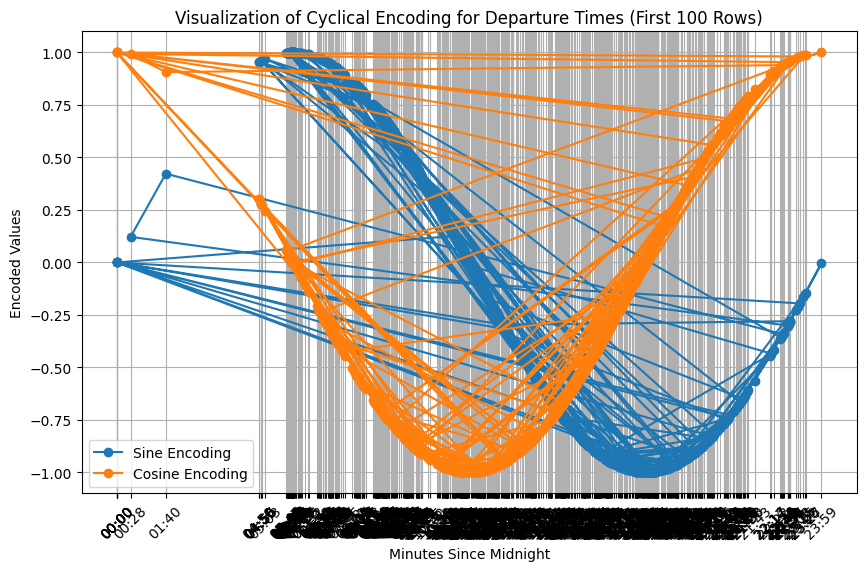

In [17]:
# Filter the DataFrame to only include the first 100 rows
filtered_data = cyclical_encoded_data_df.head(1000)

# Visualization of cyclical encoding
plt.figure(figsize=(10, 6))

# Plot sine and cosine values
plt.plot(filtered_data['Time'], filtered_data['time_sin'], label='Sine Encoding', marker='o')
plt.plot(filtered_data['Time'], filtered_data['time_cos'], label='Cosine Encoding', marker='o')

# Add labels, title, and legend
plt.title("Visualization of Cyclical Encoding for Departure Times (First 100 Rows)")
plt.xlabel("Minutes Since Midnight")
plt.ylabel("Encoded Values")
plt.xticks(filtered_data['Time'], filtered_data['time_label'], rotation=45)  # Use time labels
plt.legend()
plt.grid()
plt.show()



In [16]:
# 1. Combine 'departure_time_sin' and 'departure_time_cos' into a list of tuples
data_df['departure_time'] = list(zip(data_df['departure_time_sin'], data_df['departure_time_cos']))

# 2. Remove the original sine and cosine columns
data_df = data_df.drop(['departure_time_sin', 'departure_time_cos'], axis=1)

# Now your DataFrame 'data_df' will have a single 'departure_time' column
# containing tuples of (sin_value, cos_value).

In [17]:
data_df.head

<bound method NDFrame.head of        origin destination                             departure_time  \
0         LGA         ORF  (0.09714864061033167, 0.9952698838142168)   
1         DTW         MSN  (0.05966933989164823, 0.9982181975284237)   
2         MSP         BIS  (0.06547569540580747, 0.9978541643502451)   
3         BIS         MSP  (0.08244584060375283, 0.9965955465318619)   
4         MSN         DTW  (0.06743485000226511, 0.9977236796854989)   
...       ...         ...                                        ...   
645565    3G3         POV  (0.07592141872045746, 0.9971138040261367)   
645566   KBFI        KAPA  (0.13398618541829205, 0.9909831997148363)   
645567   PASX         PVT   (0.15930686806752256, 0.987229113117374)   
645568   PACM        PANC  (0.009817319337149617, 0.999951808959328)   
645569    LBL         LBL   (0.1254775294722748, 0.9920964618410523)   

       tail_number  incident         route  
0           N915XJ         0    LGA to ORF  
1           N90

## 4. Clean up features

In [5]:
# Your code here... For now, we don't need the tail number. Also 
# get rid of unencoded versions of the features we just handled.

## 5. Train-test split

In [6]:
# Your code here... you know the drill!

## 6. Encode route

In [7]:
# Your code here... Hint: try OrdinalEncoder(), OneHotEncoder() seems like it's the right
# thing to do - but think about why it might be problematic with this data!

## 7. Save

In [8]:
Path(config.PROCESSED_DATA_DIRECTORY).mkdir(exist_ok=True)

data_df.to_csv(config.ENCODED_DATAFILE)
train_df.to_csv(config.TRAINING_DATAFILE)
test_df.to_csv(config.TESTING_DATAFILE)

NameError: name 'train_df' is not defined